Get all imports

In [1]:
import nibabel as nib
import meshio
import pymeshlab as ml
import plotly as ply
import numpy as np

import os
from os.path import join

from api.registration_utils import segment_high_contrast, display_images, display_images_with_alpha, start_plot, end_plot, plot_values, update_multires_iterations

from skimage.feature import match_descriptors, plot_matches, SIFT

import SimpleITK as sitk
from ipywidgets import interact, fixed
from IPython.display import clear_output

Read in image files for reference and target mouse

In this case, the target mouse is the "fixed image"

In [2]:
WORKDIR = os.getcwd()
ATLAS_DIR = join(WORKDIR, "atlas")
DATA_DIR = join(WORKDIR, "data")
ASSETS_DIR = join(WORKDIR, "assets")
REFERENCE_DIR = join(ATLAS_DIR, "reference")

REF_NII = join(REFERENCE_DIR, "mouse_nii", "scaled_mouse.nii")
TARG_NII = join(ASSETS_DIR, "images", "sample", "CT_TS_HEUHR_In111_free_M1039_0h_220721-selfcal.nii")

Read in image files

In [3]:
ref_mouse = sitk.GetImageFromArray(segment_high_contrast(REF_NII, threshold=.80))
targ_mouse = sitk.GetImageFromArray(segment_high_contrast(TARG_NII, threshold=.15))

interact(display_images, 
         fixed_image_z=(0,targ_mouse.GetSize()[2]-1), 
         moving_image_z=(0,ref_mouse.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(targ_mouse)),
         moving_npa=fixed(sitk.GetArrayViewFromImage(ref_mouse)))

interactive(children=(IntSlider(value=127, description='fixed_image_z', max=255), IntSlider(value=176, descrip…

<function api.registration_utils.display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa)>

Perform initial alignment using `CenteredTransformInitializer`

In [4]:
initial_transform = sitk.CenteredTransformInitializer(targ_mouse,
                                                      ref_mouse,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

ref_resampled = sitk.Resample(ref_mouse, targ_mouse, initial_transform, sitk.sitkLinear, 0.0, ref_mouse.GetPixelID())

interact(display_images, 
         fixed_image_z=(0,targ_mouse.GetSize()[2]-1), 
         moving_image_z=(0,ref_mouse.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(targ_mouse)),
         moving_npa=fixed(sitk.GetArrayViewFromImage(ref_resampled)))

interactive(children=(IntSlider(value=127, description='fixed_image_z', max=255), IntSlider(value=176, descrip…

<function api.registration_utils.display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa)>

Perform registration using 3D rigid transformations

Similarity metric: mutual information (Mattes MI)
- Number of histogram bins: 50
- Sampling strategy: random
- Sampling percentage: 1%

Interpolator: sitkLinear

Optimizer: Gradient Descent
- LR: 1.0
- Num Iterations: 100
- Convergence tolerance: 1e-6
- Convergence window size: 10

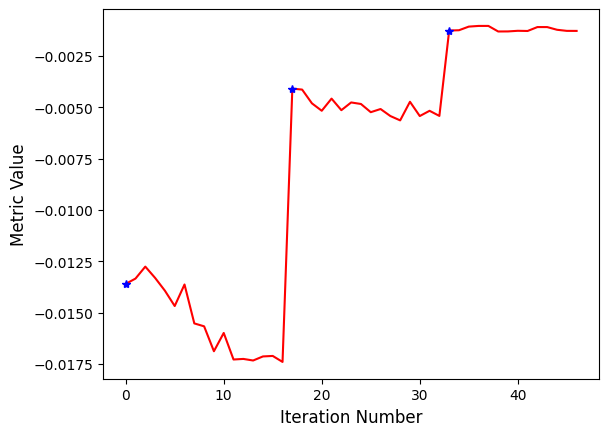

In [7]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                  numberOfIterations=1000,
                                                  convergenceMinimumValue=1e-6,
                                                  convergenceWindowSize=10)

registration_method.SetOptimizerScalesFromPhysicalShift()

registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.SetInitialTransform(initial_transform, inPlace=False)
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(targ_mouse, sitk.sitkFloat32), sitk.Cast(ref_mouse, sitk.sitkFloat32))

Analyze registration

In [10]:
ref_registered = sitk.Resample(ref_mouse, 
                              targ_mouse, 
                              final_transform, 
                              sitk.sitkLinear, 
                              0.0, 
                              ref_mouse.GetPixelID())

interact(display_images_with_alpha, image_z=(0,targ_mouse.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(targ_mouse), moving=fixed(ref_registered));

interactive(children=(IntSlider(value=127, description='image_z', max=255), FloatSlider(value=0.5, description…